In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.preprocessing import MinMaxScaler

In [2]:
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv  -o ./counties.csv
# !curl https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/deaths_timeseries.csv -o ./deaths_timeseries.csv
# !curl https://opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D -o ../data/raw/hospitals.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50.csv -o ../data/raw/DL-us-m50.csv
# !curl https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50_index.csv -o ../data/raw/DL-us-m50_index.csv
# !curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv -o ../data/raw/time_series_covid19_deaths_US_05-22.csv
# !curl https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=694ae9957380f150 -o ../data/raw/google_mobility_report_06-14-20.csv

## Pull Hospital Data

In [3]:
# Created by Michael
hospitals = pd.read_csv('../data/raw/hospitals.csv')[['TYPE', 'STATUS', 'COUNTYFIPS', 'BEDS']]
hospitals = hospitals[hospitals["STATUS"] == 'OPEN']
hospitals = hospitals[hospitals["TYPE"] == 'GENERAL ACUTE CARE']
hospitals = hospitals[hospitals["BEDS"].astype(str).astype(int) > 0]
hospitals["FIPS"] = hospitals["COUNTYFIPS"]
hospitals = hospitals[hospitals["FIPS"] != 'NOT AVAILABLE']
hospitals = hospitals.drop(["COUNTYFIPS", "STATUS"], axis=1)
hospitals["FIPS"] = hospitals["FIPS"].astype(str).astype(int)
fips_groups = hospitals.groupby("FIPS")

hosp_data = pd.DataFrame(columns=['FIPS', 'HospCt', 'Beds'])
for fips_code, grp in fips_groups:
    hosp_data = hosp_data.append({'FIPS': fips_code, 'HospCt': len(grp), 'Beds': sum(grp["BEDS"])}, ignore_index=True)   

hosp_data.head()

,FIPS,HospCt,Beds
0,1001,1,85
1,1003,3,332
2,1005,1,74
3,1007,1,35
4,1011,1,61


## County Data

In [4]:
counties = pd.read_csv('../data/raw/counties_05-08.csv')
# print(counties.columns.values)
counties = counties.dropna(how='any')
# counties['FIPS'] = counties['FIPS'] .astype('int')
counties = counties.set_index('FIPS')
# print(counties.where(counties['FIPS'] == 36061))
print(counties.loc[6037,], '\n')
# counties = counties.filter(['FIPS', 'Rural-urban_Continuum Code_2013', 'Density per square mile of land area - Population'])
counties = counties.filter(['FIPS',  'Density per square mile of land area - Population', 'Rural-urban_Continuum Code_2013', \
                            'Percent of adults with less than a high school diploma 2014-18',\
                            "Percent of adults with a bachelor's degree or higher 2014-18", 'Unemployment_rate_2018', \
                            'Med_HH_Income_Percent_of_State_Total_2018', 'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F', \
                            'Jun Temp AVG / F', 'Total_age65plus',  'Total households!!Average household size',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',\
                            'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school', 'POP_ESTIMATE_2018'])
counties = counties.dropna()
counties = counties.merge(hosp_data, left_on='FIPS', right_on='FIPS')
counties.head()

State                                              CA
Area_Name                          Los Angeles County
Rural-urban_Continuum Code_2013                     1
Urban_Influence_Code_2013                           1
Economic_typology_2015                              0
                                          ...        
Number of AGGRAVATED ASSAULTS                   23057
BURGLRY                                         49107
LARCENY                                        142604
MOTOR VEHICLE THEFTS                            40555
ARSON                                            2210
Name: 6037, Length: 346, dtype: object 



,FIPS,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,...,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Beds
0,1003,114.6,3.0,9.7,31.3,3.6,115.5,59.3,65.8,76.1,...,44571.0,2.57,3065.0,1449.0,23254.0,11209.0,6503.0,218022,3,332
1,1015,195.7,3.0,15.9,18.0,4.7,91.0,53.0,63.0,72.9,...,20247.0,2.51,1563.0,1484.0,11224.0,4972.0,6890.0,114277,3,552
2,1043,109.4,4.0,18.2,13.7,3.3,91.8,51.3,61.8,72.2,...,15446.0,2.71,734.0,547.0,8867.0,4571.0,3024.0,83442,1,145
3,1049,91.5,6.0,25.9,12.7,3.8,79.2,49.8,60.8,70.7,...,12322.0,2.66,386.0,700.0,8313.0,4354.0,1654.0,71385,1,134
4,1051,128.2,2.0,13.6,24.5,3.4,121.0,55.8,64.4,75.0,...,12400.0,2.57,1057.0,546.0,7403.0,5128.0,4022.0,81887,2,138


## Deaths Data

In [5]:
deaths_t_series = pd.read_csv('../data/raw/time_series_covid19_deaths_US_05-22.csv')
# print(filtered.loc[36061,])
# print(deaths.columns.values)
deaths_t_series = deaths_t_series.drop(['UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Population', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1)
# deaths = deaths.dropna()
# deaths = deaths.set_index('FIPS')

deaths_t_series.head()

,FIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20
0,60.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66.0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
2,69.0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
3,72.0,0,0,0,0,0,0,0,0,0,...,114,115,117,122,122,123,124,124,125,126
4,78.0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6


In [6]:
# total_deaths = pd.DataFrame(deaths.sum(axis=1), columns=['deaths'])
# total_deaths.columns = ['FIPS', 'deaths']
death_data = pd.DataFrame(columns=['FIPS', 'Deaths'])
dates = deaths_t_series.columns[1:]
death_thresh = 5
n_days = 21

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh:

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later]}, ignore_index=True)
                break

            except:
                break

death_data.head()

,FIPS,Deaths
0,66.0,5.0
1,72.0,63.0
2,1017.0,17.0
3,1055.0,10.0
4,1073.0,33.0


In [7]:
combined_data = counties.merge(death_data, left_on='FIPS', right_on='FIPS')
combined_data = combined_data.dropna()
combined_data.set_index('FIPS', inplace=True)
combined_data.head()

,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,...,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Beds,Deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1055,195.2,3.0,15.5,17.7,4.1,90.0,52.3,62.8,72.8,76.0,...,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501,2,627,10.0
1073,592.5,1.0,10.3,32.4,3.7,110.3,53.3,63.4,73.7,77.4,...,2.51,11287.0,8847.0,66358.0,32041.0,42212.0,659300,9,3866,33.0
1081,230.8,3.0,9.5,34.1,3.6,98.1,55.2,63.6,73.8,77.6,...,2.66,3126.0,1152.0,16416.0,8227.0,28826.0,163941,1,314,25.0
1095,164.4,4.0,19.1,19.2,3.4,92.7,51.1,61.9,72.4,75.6,...,2.64,849.0,1234.0,10834.0,5946.0,4040.0,96109,2,240,8.0
1097,335.9,2.0,13.8,22.9,4.7,87.4,59.5,66.1,76.4,81.0,...,2.57,6893.0,4922.0,43140.0,22358.0,20965.0,413757,4,1695,40.0


## Drop Outlier Counties

In [8]:
# combined_data = combined_data.drop(index=36061)
# combined_data = combined_data.drop(index=17031)
# combined_data = combined_data.drop(index=26163)
# combined_data = combined_data.drop(index=36059)
# combined_data = combined_data.drop(index=6037)
# combined_data = combined_data.drop(index=34013)
#36061(NY) 17031, 26163, 36059, 6037 (LA)
# combined_data.rename(columns={'Rural-urban_Continuum Code_2013': 'RUCC'}, inplace=True)
print(np.max(combined_data['Rural-urban_Continuum Code_2013']))
print(np.min(combined_data['Rural-urban_Continuum Code_2013']))
filter_high = combined_data['Rural-urban_Continuum Code_2013'] > 8
inidices_high = combined_data.where(filter_high).dropna().index.to_numpy()
filter_low = combined_data['Rural-urban_Continuum Code_2013'] < 0
inidices_low = combined_data.where(filter_low).dropna().index.to_numpy()
# print(filter.index.to_numpy().shape)
combined_data = combined_data.drop(index=inidices_low, axis=0)
combined_data = combined_data.drop(index=inidices_high, axis=0)
combined_data = combined_data.drop(columns=['Beds'])
# combined_data.set_index('FIPS', inplace=True)
combined_data.head()

6.0
1.0


,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Deaths
FIPS,,,,,,,,,,,,,,,,,,,,
1055,195.2,3.0,15.5,17.7,4.1,90.0,52.3,62.8,72.8,76.0,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501,2,10.0
1073,592.5,1.0,10.3,32.4,3.7,110.3,53.3,63.4,73.7,77.4,104547.0,2.51,11287.0,8847.0,66358.0,32041.0,42212.0,659300,9,33.0
1081,230.8,3.0,9.5,34.1,3.6,98.1,55.2,63.6,73.8,77.6,19481.0,2.66,3126.0,1152.0,16416.0,8227.0,28826.0,163941,1,25.0
1095,164.4,4.0,19.1,19.2,3.4,92.7,51.1,61.9,72.4,75.6,16375.0,2.64,849.0,1234.0,10834.0,5946.0,4040.0,96109,2,8.0
1097,335.9,2.0,13.8,22.9,4.7,87.4,59.5,66.1,76.4,81.0,67041.0,2.57,6893.0,4922.0,43140.0,22358.0,20965.0,413757,4,40.0


In [9]:
combined_data.head()

,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Deaths
FIPS,,,,,,,,,,,,,,,,,,,,
1055,195.2,3.0,15.5,17.7,4.1,90.0,52.3,62.8,72.8,76.0,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501,2,10.0
1073,592.5,1.0,10.3,32.4,3.7,110.3,53.3,63.4,73.7,77.4,104547.0,2.51,11287.0,8847.0,66358.0,32041.0,42212.0,659300,9,33.0
1081,230.8,3.0,9.5,34.1,3.6,98.1,55.2,63.6,73.8,77.6,19481.0,2.66,3126.0,1152.0,16416.0,8227.0,28826.0,163941,1,25.0
1095,164.4,4.0,19.1,19.2,3.4,92.7,51.1,61.9,72.4,75.6,16375.0,2.64,849.0,1234.0,10834.0,5946.0,4040.0,96109,2,8.0
1097,335.9,2.0,13.8,22.9,4.7,87.4,59.5,66.1,76.4,81.0,67041.0,2.57,6893.0,4922.0,43140.0,22358.0,20965.0,413757,4,40.0


## Mobility Data

In [10]:
dl_index = pd.read_csv('../data/raw/DL-us-m50_index_05-22.csv')
dl_abs_movement = pd.read_csv('../data/raw/DL-us-m50_05-22.csv')
dl_index = dl_index.dropna()
dl_abs_movement = dl_abs_movement.dropna()
dl = dl_index.merge(dl_abs_movement, on='fips')
print(dl.head())

baseline1 = pd.DataFrame(dl['2020-03-01_y'] / (.01 * dl['2020-03-01_x']))
baseline2 = pd.DataFrame(dl['2020-03-02_y'] / (.01 * dl['2020-03-02_x']))
baseline3 = pd.DataFrame(dl['2020-03-03_y'] / (.01 * dl['2020-03-03_x']))
baselines = pd.concat((baseline1, baseline2, baseline3), axis=1)

pd.set_option('display.max_rows', None)
dl['baseline'] = baselines.mean(axis=1)
baseline_data = dl[['baseline', 'fips']]
baseline_data['FIPS'] = baseline_data['fips']
baseline_data = baseline_data.drop(['fips'], axis=1)
baseline_data.set_index('FIPS', inplace=True)
baseline_data.head()

  country_code_x  admin_level_x admin1_x        admin2_x    fips  \
0             US              2  Alabama  Autauga County  1001.0   
1             US              2  Alabama  Baldwin County  1003.0   
2             US              2  Alabama  Barbour County  1005.0   
3             US              2  Alabama     Bibb County  1007.0   
4             US              2  Alabama   Blount County  1009.0   

   2020-03-01_x  2020-03-02_x  2020-03-03_x  2020-03-04_x  2020-03-05_x  ...  \
0          49.0         100.0          95.0          95.0         100.0  ...   
1          81.0         100.0          95.0          90.0         102.0  ...   
2          90.0         107.0         100.0          70.0          88.0  ...   
3          53.0          95.0         100.0          94.0         111.0  ...   
4          68.0          96.0         100.0          99.0         101.0  ...   

   2020-05-10_y  2020-05-11_y  2020-05-12_y  2020-05-13_y  2020-05-14_y  \
0         5.914         8.067      

/Users/beatrizmedeiros/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,baseline
FIPS,
1001.0,14.621123
1003.0,12.067112
1005.0,9.297363
1007.0,24.332641
1009.0,23.362889


In [11]:
combined_data = baseline_data.merge(combined_data, left_on='FIPS', right_on='FIPS')
combined_data.head(50)

,baseline,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,...,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,POP_ESTIMATE_2018,HospCt,Deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1055.0,9.411457,195.2,3.0,15.5,17.7,4.1,90.0,52.30,62.80,72.80,...,19487.0,2.62,1066.0,1299.0,10215.0,4628.0,4019.0,102501,2,10.0
1073.0,9.981023,592.5,1.0,10.3,32.4,3.7,110.3,53.30,63.40,73.70,...,104547.0,2.51,11287.0,8847.0,66358.0,32041.0,42212.0,659300,9,33.0
1081.0,7.074980,230.8,3.0,9.5,34.1,3.6,98.1,55.20,63.60,73.80,...,19481.0,2.66,3126.0,1152.0,16416.0,8227.0,28826.0,163941,1,25.0
1095.0,10.517269,164.4,4.0,19.1,19.2,3.4,92.7,51.10,61.90,72.40,...,16375.0,2.64,849.0,1234.0,10834.0,5946.0,4040.0,96109,2,8.0
1097.0,9.533634,335.9,2.0,13.8,22.9,4.7,87.4,59.50,66.10,76.40,...,67041.0,2.57,6893.0,4922.0,43140.0,22358.0,20965.0,413757,4,40.0
1101.0,7.400293,292.5,2.0,14.4,32.1,4.0,99.5,56.90,65.00,75.70,...,34173.0,2.50,2222.0,3019.0,23294.0,12842.0,14710.0,225763,3,8.0
4001.0,4.295518,6.4,6.0,20.4,11.7,10.1,57.0,51.80,59.40,58.60,...,10986.0,3.22,610.0,1468.0,9553.0,4861.0,2398.0,71818,1,11.0
4005.0,4.281449,7.2,3.0,10.4,35.6,5.5,101.9,47.60,57.10,56.80,...,17855.0,2.70,1657.0,2093.0,13931.0,6169.0,26002.0,142854,3,35.0
4013.0,8.702696,414.9,1.0,12.6,32.0,4.1,110.4,52.80,61.00,59.50,...,669285.0,2.75,53212.0,54502.0,476933.0,237397.0,287846.0,4410824,34,69.0


## Google Mobility data 

In [12]:
# google_mobility = pd.read_csv('../data/raw/google_mobility_report_06-14-20.csv')
# google_mobility.head()
## not used 

In [13]:
combined_data.columns.values

array(['baseline', 'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       "Percent of adults with a bachelor's degree or higher 2014-18",
       'Unemployment_rate_2018',
       'Med_HH_Income_Percent_of_State_Total_2018', 'Mar Temp AVG / F',
       'Apr Temp AVG / F', 'May Temp AVG / F', 'Jun Temp AVG / F',
       'Total_age65plus', 'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate sc

In [14]:
# combined_data['normalized_deaths'] = np.true_divide(combined_data['Deaths'],combined_data['POP_ESTIMATE_2018'])
# combined_data['HospCt'] = np.true_divide(combined_data['HospCt'],combined_data['POP_ESTIMATE_2018'])
# combined_data.head()

## Normalize by Population

In [15]:
combined_data['normalized_deaths'] = np.true_divide(combined_data['Deaths'],combined_data['POP_ESTIMATE_2018'])
combined_data['Total_age65plus'] = np.true_divide(combined_data['Total_age65plus'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)'],combined_data['POP_ESTIMATE_2018'])
combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'] = np.true_divide(combined_data['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school'],combined_data['POP_ESTIMATE_2018'])
combined_data['HospCt'] = np.true_divide(combined_data['HospCt'],combined_data['POP_ESTIMATE_2018'])

In [16]:
# drop population 
combined_data.drop(columns='POP_ESTIMATE_2018', inplace=True)
combined_data.head()

,baseline,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,...,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1055.0,9.411457,195.2,3.0,15.5,17.7,4.1,90.0,52.3,62.8,72.8,...,0.190115,2.62,0.010400,0.012673,0.099658,0.045151,0.039209,1.9512e-05,10.0,0.000098
1073.0,9.981023,592.5,1.0,10.3,32.4,3.7,110.3,53.3,63.4,73.7,...,0.158573,2.51,0.017120,0.013419,0.100649,0.048599,0.064025,1.36508e-05,33.0,0.000050
1081.0,7.074980,230.8,3.0,9.5,34.1,3.6,98.1,55.2,63.6,73.8,...,0.118829,2.66,0.019068,0.007027,0.100134,0.050183,0.175832,6.09976e-06,25.0,0.000152
1095.0,10.517269,164.4,4.0,19.1,19.2,3.4,92.7,51.1,61.9,72.4,...,0.170379,2.64,0.008834,0.012840,0.112726,0.061867,0.042036,2.08097e-05,8.0,0.000083
1097.0,9.533634,335.9,2.0,13.8,22.9,4.7,87.4,59.5,66.1,76.4,...,0.162030,2.57,0.016660,0.011896,0.104264,0.054037,0.050670,9.66751e-06,40.0,0.000097


## Min/Max Scaling / Normalization 

In [17]:
scaler = MinMaxScaler() 
print(combined_data.to_numpy().shape)
scaled_data = scaler.fit_transform(combined_data)
for i in range(len(combined_data.columns.values)): 
    col = combined_data.columns.values[i]
    combined_data[col] = scaled_data[:, i]

(397, 21)


In [18]:
print(combined_data.max(axis=0))
print(combined_data.min(axis=0))
combined_data.head()

baseline                                                                                             1.0
Density per square mile of land area - Population                                                    1.0
Rural-urban_Continuum Code_2013                                                                      1.0
Percent of adults with less than a high school diploma 2014-18                                       1.0
Percent of adults with a bachelor's degree or higher 2014-18                                         1.0
Unemployment_rate_2018                                                                               1.0
Med_HH_Income_Percent_of_State_Total_2018                                                            1.0
Mar Temp AVG / F                                                                                     1.0
Apr Temp AVG / F                                                                                     1.0
May Temp AVG / F                                       

,baseline,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,...,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1055.0,0.449395,0.002718,0.4,0.402985,0.122490,0.135802,0.222485,0.697723,0.736148,0.781775,...,0.203494,0.325792,0.294336,0.358494,0.567540,0.342774,0.075155,0.261462,0.000986,0.028791
1073.0,0.483877,0.008438,0.0,0.247761,0.417671,0.111111,0.342604,0.718427,0.751979,0.803357,...,0.138366,0.276018,0.520694,0.386817,0.576102,0.400644,0.172229,0.169115,0.005521,0.013511
1081.0,0.307942,0.003231,0.4,0.223881,0.451807,0.104938,0.270414,0.757764,0.757256,0.805755,...,0.056305,0.343891,0.586319,0.144048,0.571650,0.427235,0.609583,0.050141,0.003943,0.046459
1095.0,0.516342,0.002275,0.6,0.510448,0.152610,0.092593,0.238462,0.672878,0.712401,0.772182,...,0.162744,0.334842,0.241579,0.364819,0.680389,0.623360,0.086210,0.281908,0.000591,0.024185
1097.0,0.456792,0.004744,0.2,0.352239,0.226908,0.172840,0.207101,0.846791,0.823219,0.868106,...,0.145504,0.303167,0.505194,0.328976,0.607318,0.491922,0.119985,0.106354,0.006901,0.028506


Text(0, 0.5, 'total deaths')

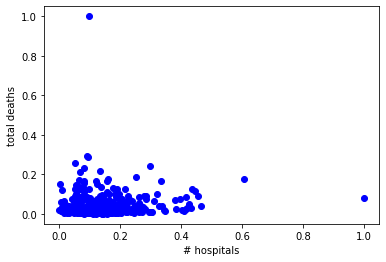

In [19]:
plt.plot(list(combined_data['HospCt']), list(combined_data['normalized_deaths']), 'bo')
plt.xlabel('# hospitals')
plt.ylabel('total deaths')

In [20]:
filter1 = combined_data['Deaths'] > 140
# filter2 = combined_data['deaths'] > 300000
filtered = combined_data.where(filter1)
# filtered.where(filter2, inplace=True)
filtered = filtered.dropna()
filtered.head()

,baseline,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,...,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,


In [21]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2].reshape(1, -1).T
Y = data_arr[:,3].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.049181460930835086

In [22]:
data_arr = combined_data.to_numpy()
X = data_arr[:,2:10].reshape(8, -1).T
Y = data_arr[:,10].reshape(1, -1).T
reg = lm.LinearRegression().fit(X,Y)
reg.score(X,Y)

0.01705079916973906

In [23]:
combined_data.to_csv('../data/intermediates/pre_acpca1.csv')
combined_data.shape

(397, 21)

In [24]:
len(combined_data.columns)

21

In [25]:
print(combined_data.columns[0:20])

Index(['baseline', 'Density per square mile of land area - Population',
       'Rural-urban_Continuum Code_2013',
       'Percent of adults with less than a high school diploma 2014-18',
       'Percent of adults with a bachelor's degree or higher 2014-18',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018',
       'Mar Temp AVG / F', 'Apr Temp AVG / F', 'May Temp AVG / F',
       'Jun Temp AVG / F', 'Total_age65plus',
       'Total households!!Average household size',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',
       'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate sc

In [26]:
combined_data.head()

,baseline,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Unemployment_rate_2018,Med_HH_Income_Percent_of_State_Total_2018,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,...,Total_age65plus,Total households!!Average household size,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school preschool,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten,SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12),SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school,HospCt,Deaths,normalized_deaths
FIPS,,,,,,,,,,,,,,,,,,,,,
1055.0,0.449395,0.002718,0.4,0.402985,0.122490,0.135802,0.222485,0.697723,0.736148,0.781775,...,0.203494,0.325792,0.294336,0.358494,0.567540,0.342774,0.075155,0.261462,0.000986,0.028791
1073.0,0.483877,0.008438,0.0,0.247761,0.417671,0.111111,0.342604,0.718427,0.751979,0.803357,...,0.138366,0.276018,0.520694,0.386817,0.576102,0.400644,0.172229,0.169115,0.005521,0.013511
1081.0,0.307942,0.003231,0.4,0.223881,0.451807,0.104938,0.270414,0.757764,0.757256,0.805755,...,0.056305,0.343891,0.586319,0.144048,0.571650,0.427235,0.609583,0.050141,0.003943,0.046459
1095.0,0.516342,0.002275,0.6,0.510448,0.152610,0.092593,0.238462,0.672878,0.712401,0.772182,...,0.162744,0.334842,0.241579,0.364819,0.680389,0.623360,0.086210,0.281908,0.000591,0.024185
1097.0,0.456792,0.004744,0.2,0.352239,0.226908,0.172840,0.207101,0.846791,0.823219,0.868106,...,0.145504,0.303167,0.505194,0.328976,0.607318,0.491922,0.119985,0.106354,0.006901,0.028506
